<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/Autoencoder_YRBSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

In [1]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 165 (delta 26), reused 0 (delta 0), pack-reused 123
Receiving objects: 100% (165/165), 3.77 MiB | 633.00 KiB/s, done.
Resolving deltas: 100% (92/92), done.
/content/autoencoders_census


In [2]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import DataTransformer
from data_loader import DataLoader
from autoencoder import AutoencoderModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.4 MB/s eta 0:00:00
importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from autoencoder.ipynb


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from pandas.api.types import is_numeric_dtype
from matplotlib.offsetbox import TransformedBbox

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [6]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [7]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [8]:
# Data Source
data_loader = DataLoader()
original_df = data_loader.load_original_data()
project_data, variable_types = data_loader.prepare_original_dataset(original_df)



In [9]:
original_df.shape

(14765, 305)

In [10]:
project_data.shape

(14765, 108)

# Transforming the original data set

In [11]:
# Data Transformation
data_transformer = DataTransformer(variable_types)


# Without indicator variables for missingness
transformed_df = data_transformer.transform_dataframe(project_data)

# If we want to add indicators for missing values, but we need to also add the appropriate variable types for the missing
# project_data_missing = data_transformer.add_missing_indicators(project_data)
# transformed_df = data_transformer.transform_dataframe(project_data_missing)


In [12]:
transformed_df.shape

(14765, 666)

In [13]:
# This does not work. Need to figure out why.
# data_transformer.reverse_transform_dataframe(transformed_df)

# Autoencoder training

## Hyperparameter search and model training

The training of an autoencoder model while effectively handling missing data with mask variables.

In [14]:
# Instantiate the class
model = AutoencoderModel()

# Preprocess the data
X_train, X_test = model.split_train_test(transformed_df)

In [15]:
# Define the tuner
tuner = model.define_tuner()

# Perform hyperparameter search
tuner.search(X_train, X_train, epochs=model.EPOCHS,
             # batch_size=model.BATCH_SIZE,
             validation_data=(X_test, X_test))

# Get the best hyperparameters and build the final model
best_hps = tuner.get_best_hyperparameters(num_trials=model.NUM_TRIALS)[0]
final_model = model.build_autoencoder(best_hps)

Trial 20 Complete [00h 00m 23s]
val_loss: 0.05942916497588158

Best val_loss So Far: 0.059057168662548065
Total elapsed time: 00h 07m 33s


In [16]:
best_hps.__dict__

{'_name_scopes': [],
 '_conditions': [],
 '_hps': defaultdict(list,
             {'learning_rate': [Choice(name: 'learning_rate', values: [1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05], ordered: True, default: 1.0)],
              'batch_size': [Int(name: 'batch_size', min_value: 16, max_value: 256, step: 16, sampling: linear, default: 16)],
              'encoder_units_1': [Int(name: 'encoder_units_1', min_value: 16, max_value: 256, step: 16, sampling: linear, default: 16)],
              'encoder_units_2': [Int(name: 'encoder_units_2', min_value: 16, max_value: 128, step: 16, sampling: linear, default: 16)],
              'decoder_units_1': [Int(name: 'decoder_units_1', min_value: 16, max_value: 256, step: 16, sampling: linear, default: 16)],
              'decoder_units_2': [Int(name: 'decoder_units_2', min_value: 16, max_value: 256, step: 16, sampling: linear, default: 16)]}),
 '_space': [Choice(name: 'learning_rate', values: [1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05], ordered: True, default: 

In [17]:
# Train the final model
history = final_model.fit(X_train, X_train,
                           epochs=5*model.EPOCHS,
                           verbose=1,
                           validation_data=(X_test, X_test))

Epoch 1/25
329/329 [==============================] - 6s 8ms/step - loss: 0.0799 - val_loss: 0.0694
Epoch 2/25
329/329 [==============================] - 2s 7ms/step - loss: 0.0630 - val_loss: 0.0608
Epoch 3/25
329/329 [==============================] - 3s 10ms/step - loss: 0.0619 - val_loss: 0.0607
Epoch 4/25
329/329 [==============================] - 3s 8ms/step - loss: 0.0612 - val_loss: 0.0614
Epoch 5/25
329/329 [==============================] - 2s 8ms/step - loss: 0.0611 - val_loss: 0.0613
Epoch 6/25
329/329 [==============================] - 2s 8ms/step - loss: 0.0606 - val_loss: 0.0601
Epoch 7/25
329/329 [==============================] - 3s 8ms/step - loss: 0.0605 - val_loss: 0.0590
Epoch 8/25
329/329 [==============================] - 3s 10ms/step - loss: 0.0605 - val_loss: 0.0584
Epoch 9/25
329/329 [==============================] - 3s 8ms/step - loss: 0.0603 - val_loss: 0.0596
Epoch 10/25
329/329 [==============================] - 3s 8ms/step - loss: 0.0602 - val_loss: 0.05

Visualize the training and validation loss values over epochs.

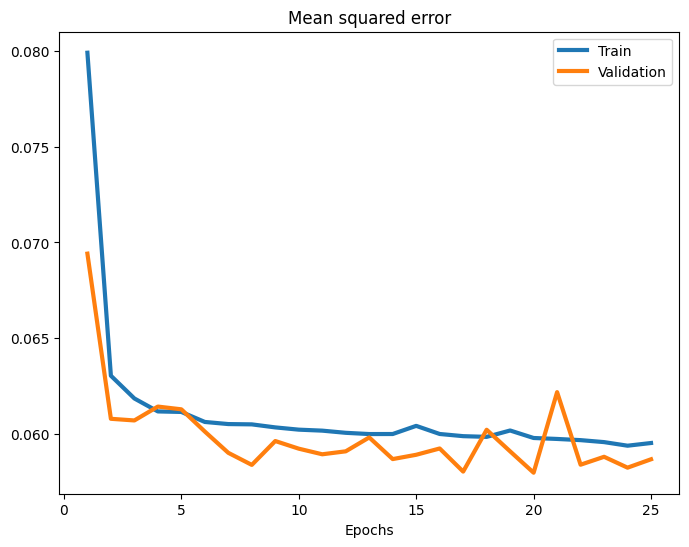

Training MSE = 0.2439775074588672
Validation MSE = 0.24223012702877067


In [18]:
def model_analysis(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))
    plt.title("Mean squared error")
    sns.lineplot(x=epochs, y=train_loss, label="Train", linewidth=3)
    sns.lineplot(x=epochs, y=val_loss, label="Validation", linewidth=3)
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

    print(f"Training MSE = {np.sqrt(train_loss[-1])}")
    print(f"Validation MSE = {np.sqrt(val_loss[-1])}")

model_analysis(history.history['loss'], history.history['val_loss'])

In [19]:
# Save the model as a .h5 file
model_filename = "Hyperparameter.h5"
final_model.save(model_filename)

# Store the hyperparameters and evaluation metrics in a dictionary
hyperparameters_dict = {"learning_rate": best_hps.get('learning_rate'),
                        "batch_size": best_hps.get('batch_size'),
                        "num_epochs": 10,
                        "loss": history.history['loss'][-1],
                        "val_loss": history.history['val_loss'][-1]}

## Making Predictions and Filling in the Missing Values


In [20]:
import numpy as np

# Fill the missing values with some initial guess. Here, the median of each column is used.
filled = transformed_df.fillna(transformed_df.median())

# Define a condition for stopping the iteration
epsilon = 1e-4
old_filled = None

while old_filled is None or np.abs(filled - old_filled).sum().sum() > epsilon:
  # Save the old filled DataFrame for convergence check
  old_filled = filled.copy()

  # Run the data through the autoencoder, which will return a complete version of the data.
  predicted = final_model.predict(filled)

  # Replace the initially guessed values in the original data with the corresponding values from the autoencoder's output. But keep the observed values unchanged.
  mask = transformed_df.isna()
  filled[mask] = np.where(mask, predicted, filled)


462/462 [==============================] - 1s 3ms/step


In [21]:
filled

,weight,stheight,stweight,bmi,bmipct,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,...,sunburn_5 or more times,sunburn_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,how_well_speak_English_Not at all,how_well_speak_English_Not well,how_well_speak_English_Very well,how_well_speak_English_Well,how_well_speak_English_nan
0,0.508875,0.493335,0.289052,0.134481,0.663872,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.347927,0.479268,0.260172,0.109777,0.711098,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.142144,0.493335,0.289052,0.134481,0.663872,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.161873,0.493335,0.289052,0.134481,0.663872,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.415955,0.494508,0.232872,0.102197,0.630087,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14760,0.018136,0.536230,0.254820,0.088412,0.621310,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
14761,0.030378,0.536374,0.257400,0.088264,0.623464,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
14762,0.021987,0.536682,0.255927,0.088083,0.622132,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
14763,0.087971,0.577465,0.188926,0.082226,0.089027,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [22]:
transformed_df.shape

(14765, 666)

In [23]:
filled.shape

(14765, 666)

In [24]:
# data_transformer.reverse_transform_dataframe(filled)


In [25]:



# Repeat steps 2 and 3 for a number of times or until the changes in the imputed values become small enough.

## Examine Training Output Statistics

Visualize the empirical distribution function of the latent representation obtained from the encoder model.

In [26]:
final_model.predict(filled)[0,:]

462/462 [==============================] - 1s 2ms/step


array([ 2.57297873e-01,  4.93334770e-01,  2.89051861e-01,  1.34480789e-01,
        6.63871944e-01,  1.28065012e-02, -2.73408387e-02,  3.79364789e-02,
        1.49923086e-01,  2.35582978e-01,  3.28790307e-01,  2.50391483e-01,
        2.58839838e-02,  5.96333385e-01,  4.05666947e-01, -4.54806276e-02,
        1.78207695e-01,  3.14964712e-01,  3.60345423e-01,  1.54298753e-01,
        3.26042101e-02,  8.37388560e-02,  1.23904020e-01,  3.00133944e-01,
        4.64015216e-01,  1.17187072e-02, -8.63708742e-03,  3.68005261e-02,
        1.26342729e-01,  3.00479263e-01,  7.13996738e-02,  1.13047864e-02,
        4.65882599e-01, -6.89579826e-03,  8.70788753e-01,  1.25893727e-01,
       -3.00098415e-02,  8.27037275e-01,  1.77191973e-01,  1.26472721e-03,
        1.23853505e-01,  4.91590574e-02,  8.49279523e-01,  3.98286879e-02,
       -2.22249217e-02,  3.93034339e-01,  8.75432193e-02,  4.53256965e-01,
        1.08229160e-01, -2.57684439e-02,  1.24931864e-01,  4.34009023e-02,
        8.47435594e-01,  

Assess the quality of the autoencoder's reconstruction by calculating the Mean Absolute Error (MAE) between the reconstructed data and the original data.

462/462 [==============================] - 1s 2ms/step


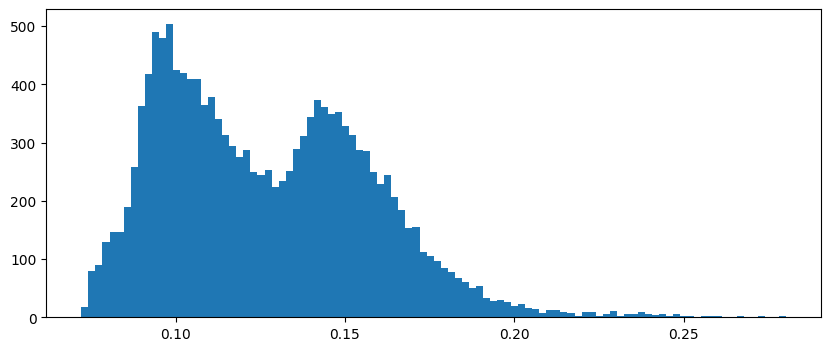

In [27]:
plt.figure(figsize=(10, 4))
# reconstruct the original data
normal_reconstructions = final_model.predict(filled)
# compute the Mean Absolute Error between the reconstructed data and the original data
normal_loss = tf.losses.mae(normal_reconstructions,filled)
plt.hist(normal_loss, bins=100)
plt.show()

The threshold value based on the mean and standard deviation of the reconstruction error. This threshold provides a reference point for distinguishing between normal reconstruction errors and potential outliers.

In [28]:
threshold = np.mean(normal_loss) + 2*np.std(normal_loss)
print(threshold)

0.1886975832460988


Visualize the distribution of the reconstruction errors and highlight the threshold for identifying outliers in the reconstruction error.

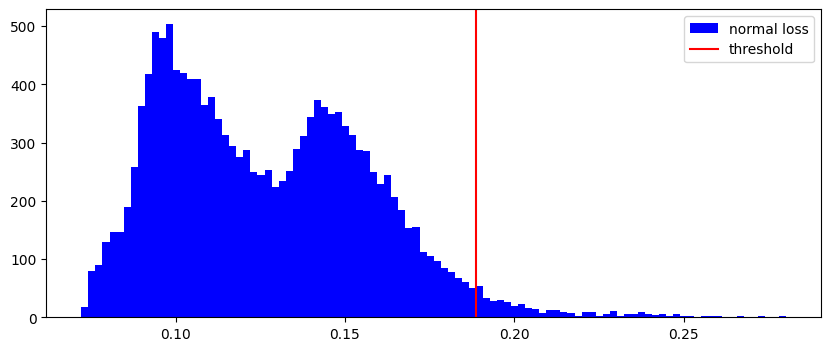

In [29]:
plt.figure(figsize=(10, 4))
plt.hist(normal_loss, bins=100, color='b', label="normal loss")
# add a vertical line to the plot at the position of the threshold value
plt.axvline(threshold, color='r', label="threshold")
plt.legend()
plt.show()

In [30]:
normal_loss

<tf.Tensor: shape=(14765,), dtype=float64, numpy=
array([0.16981021, 0.133756  , 0.18196962, ..., 0.18838216, 0.10361038,
       0.1706088 ])>

In [31]:
reconstructed_error_df = pd.DataFrame()
reconstructed_error_df['Reconstructed_Error'] = normal_loss
reconstructed_error_df.to_csv('data_with_reconstructed_errors.csv', index=False)
reconstructed_error_df.head()

,Reconstructed_Error
0,0.169810
1,0.133756
2,0.181970
3,0.187910
4,0.125574


Obtain the indices in descending order of the reconstruction errors.

In [32]:
sorted_indices = np.argsort(normal_loss)[::-1]

Identify and extract a subset of samples from the original dataset that have the 100 highest reconstruction errors and have reconstruction errors exceeding the threshold value.

In [33]:

k = 100  # Number of samples to select
samples_with_high_error = transformed_df.iloc[sorted_indices[:k]]
samples_with_high_error.head()

,weight,stheight,stweight,bmi,bmipct,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,...,sunburn_5 or more times,sunburn_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,how_well_speak_English_Not at all,how_well_speak_English_Not well,how_well_speak_English_Very well,how_well_speak_English_Well,how_well_speak_English_nan
129,0.046169,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2845,0.310901,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
29,0.638196,NaN,NaN,0.157129,NaN,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
14232,0.237430,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
123,0.292636,NaN,NaN,1.000000,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [34]:
# Find indices of tuples with reconstruction values larger than the threshold
anomaly_indices = np.where(normal_loss > threshold)[0]

# Select the corresponding tuples from the original data
anomaly_tuples = transformed_df.iloc[anomaly_indices]

# Print the anomaly tuples
anomaly_tuples.head()


,weight,stheight,stweight,bmi,bmipct,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,...,sunburn_5 or more times,sunburn_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,how_well_speak_English_Not at all,how_well_speak_English_Not well,how_well_speak_English_Very well,how_well_speak_English_Well,how_well_speak_English_nan
7,0.356232,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
12,0.211872,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
15,0.043351,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22,0.243433,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
27,0.091672,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
anomaly_tuples.shape

(404, 666)

Reconstruct the transformed data using the trained autoencoder model and get the combined dataframe of the original transformed data with its reconstructed version.

In [36]:

reconstructed_data = final_model.predict(filled)

reconstructed_df = pd.DataFrame(reconstructed_data, columns=transformed_df.columns)

combined_df = pd.concat([transformed_df, reconstructed_df], axis=1)
combined_df.head()

462/462 [==============================] - 2s 3ms/step


,weight,stheight,stweight,bmi,bmipct,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,...,sunburn_5 or more times,sunburn_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,how_well_speak_English_Not at all,how_well_speak_English_Not well,how_well_speak_English_Very well,how_well_speak_English_Well,how_well_speak_English_nan
0,0.508875,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.091391,-0.014718,0.658026,0.353233,-0.001246,-0.016222,-0.010317,0.910520,0.124862,-0.005017
1,0.347927,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.087943,-0.032616,0.667694,0.358125,-0.025903,-0.007487,-0.011533,0.859656,0.175892,-0.018646
2,0.142144,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.091391,-0.014718,0.658026,0.353233,-0.001246,-0.016222,-0.010317,0.910520,0.124862,-0.005017
3,0.161873,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.091391,-0.014718,0.658026,0.353233,-0.001246,-0.016222,-0.010317,0.910520,0.124862,-0.005017
4,0.415955,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,0.030490,0.825800,0.147679,0.018928,0.830770,0.001189,-0.031874,0.172980,0.015672,0.838372


In [37]:
reconstructed_data1 = final_model.predict(transformed_df)
reconstructed_df1 = pd.DataFrame(reconstructed_data, columns=transformed_df.columns)
columns_to_modify = ["weight","stheight","stweight","bmi","bmipct"]
transformed_df[columns_to_modify] = transformed_df[columns_to_modify].replace(0, np.nan)

reconstructed_df1.head()

462/462 [==============================] - 2s 5ms/step


,weight,stheight,stweight,bmi,bmipct,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,...,sunburn_5 or more times,sunburn_nan,difficulty_concentrating_No,difficulty_concentrating_Yes,difficulty_concentrating_nan,how_well_speak_English_Not at all,how_well_speak_English_Not well,how_well_speak_English_Very well,how_well_speak_English_Well,how_well_speak_English_nan
0,0.257298,0.493335,0.289052,0.134481,0.663872,0.012807,-0.027341,0.037936,0.149923,0.235583,...,0.091391,-0.014718,0.658026,0.353233,-0.001246,-0.016222,-0.010317,0.910520,0.124862,-0.005017
1,0.223365,0.479268,0.260172,0.109777,0.711098,0.010467,0.022966,0.262830,0.415945,0.182031,...,0.087943,-0.032616,0.667694,0.358125,-0.025903,-0.007487,-0.011533,0.859656,0.175892,-0.018646
2,0.257298,0.493335,0.289052,0.134481,0.663872,0.012807,-0.027341,0.037936,0.149923,0.235583,...,0.091391,-0.014718,0.658026,0.353233,-0.001246,-0.016222,-0.010317,0.910520,0.124862,-0.005017
3,0.257298,0.493335,0.289052,0.134481,0.663872,0.012807,-0.027341,0.037936,0.149923,0.235583,...,0.091391,-0.014718,0.658026,0.353233,-0.001246,-0.016222,-0.010317,0.910520,0.124862,-0.005017
4,0.133108,0.494508,0.232872,0.102197,0.630087,-0.003077,0.011223,0.348741,0.498973,0.137617,...,0.030490,0.825800,0.147679,0.018928,0.830770,0.001189,-0.031874,0.172980,0.015672,0.838372


Calculate the cost standardization and map reconstructed binary values to categories.

\#1 approach for getting cost values:

In [38]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

cost = {}
mapped_categories = {}

for column in transformed_df[categorical_vars]:
  probability = transformed_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost[column] = cost_value

for column, cost in cost.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories[column] = (reconstructed_df[column] > cost).astype(int)

In [39]:
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

cost1 = {}
mapped_categories1 = {}

for column in transformed_df[categorical_vars]:
  probability = transformed_df[column].mean(axis=0)
  cost_value = np.where(probability != 0, (1 / probability) * 0.01, np.inf)

  cost1[column] = cost_value

for column, cost in cost1.items():
    # Map the reconstructed values to categories based on the threshold
    mapped_categories1[column] = (reconstructed_df1[column] > cost).astype(int)

Evaluate the performance of the reconstructed categories compared to the original dataset. A higher AUC score indicates better performance in distinguishing different instances.

In [40]:
auc_scores = {}

for column in mapped_categories:

    mapped_values = mapped_categories[column]
    true_labels = transformed_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)

    auc_scores[column] = roc_auc

auc_scores

{'age_12 years old or younger': 0.5,
 'age_13 years old': 0.5,
 'age_14 years old': 0.6637356879363461,
 'age_15 years old': 0.5,
 'age_16 years old': 0.5,
 'age_17 years old': 0.5285029500887031,
 'age_18 years old or older': 0.6246637733529724,
 'age_nan': 0.5,
 'sex_Female': 0.5,
 'sex_Male': 0.5,
 'sex_nan': 0.5,
 'grade_10th': 0.5,
 'grade_11th': 0.5020067086262955,
 'grade_12th': 0.5367612583055437,
 'grade_9th': 0.5,
 'grade_nan': 0.5,
 'Hispanic_or_Latino_All other races': 0.5630060894864688,
 'Hispanic_or_Latino_Black or African American': 0.5724800841611455,
 'Hispanic_or_Latino_Hispanic/Latino': 0.539724079598206,
 'Hispanic_or_Latino_White': 0.5,
 'Hispanic_or_Latino_nan': 0.5,
 'race_Am Indian / Alaska Native': 0.5,
 'race_Asian': 0.5,
 'race_Black or African American': 0.5725218587454883,
 'race_Hispanic/Latino': 0.5399402096502198,
 'race_Multiple - Non-Hispanic': 0.5,
 'race_Native Hawaiian/other PI': 0.5,
 'race_White': 0.5,
 'race_nan': 0.5,
 'obese_not obese': 0.5,
 

In [41]:
from sklearn.metrics import confusion_matrix

num_categories = len(categorical_vars)
confusion_matrices = {}

for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = mapped_categories[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

Confusion Matrix for age_12 years old or younger:
[[14706     0]
 [   59     0]]

Confusion Matrix for age_13 years old:
[[14743     0]
 [   22     0]]

Confusion Matrix for age_14 years old:
[[6638 6205]
 [ 364 1558]]

Confusion Matrix for age_15 years old:
[[    0 11179]
 [    0  3586]]

Confusion Matrix for age_16 years old:
[[    0 11077]
 [    0  3688]]

Confusion Matrix for age_17 years old:
[[  954 10200]
 [  103  3508]]

Confusion Matrix for age_18 years old or older:
[[6483 6486]
 [ 450 1346]]

Confusion Matrix for age_nan:
[[14684     0]
 [   81     0]]

Confusion Matrix for sex_Female:
[[   0 7239]
 [   0 7526]]

Confusion Matrix for sex_Male:
[[   0 7653]
 [   0 7112]]

Confusion Matrix for sex_nan:
[[14638     0]
 [  127     0]]

Confusion Matrix for grade_10th:
[[    0 11050]
 [    0  3715]]

Confusion Matrix for grade_11th:
[[   51 11112]
 [    2  3600]]

Confusion Matrix for grade_12th:
[[ 1143 10239]
 [   91  3292]]

Confusion Matrix for grade_9th:
[[    0 10844]
 [   

In [42]:
merged_df = (pd.DataFrame(mapped_categories)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df.head(10)

,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,age_17 years old,age_18 years old or older,age_nan,sex_Female,sex_Male,...,how_well_speak_English_Not at all,how_well_speak_English_Not well,how_well_speak_English_Very well,how_well_speak_English_Well,how_well_speak_English_nan,weight,stheight,stweight,bmi,bmipct
0,0,0,0,1,1,1,1,0,1,1,...,0,0,1,1,0,0.257298,0.493335,0.289052,0.134481,0.663872
1,0,0,1,1,1,1,0,0,1,1,...,0,0,1,1,0,0.223365,0.479268,0.260172,0.109777,0.711098
2,0,0,0,1,1,1,1,0,1,1,...,0,0,1,1,0,0.257298,0.493335,0.289052,0.134481,0.663872
3,0,0,0,1,1,1,1,0,1,1,...,0,0,1,1,0,0.257298,0.493335,0.289052,0.134481,0.663872
4,0,0,1,1,1,0,0,0,1,1,...,0,0,1,0,1,0.133108,0.494508,0.232872,0.102197,0.630087
5,0,0,0,1,1,1,1,0,1,1,...,0,0,1,1,0,0.257298,0.493335,0.289052,0.134481,0.663872
6,0,0,0,1,1,1,1,0,1,1,...,0,0,1,1,0,0.257298,0.493335,0.289052,0.134481,0.663872
7,0,0,1,1,1,1,1,0,1,1,...,0,0,1,1,0,0.233382,0.481393,0.283661,0.120916,0.726394
8,0,0,1,1,1,1,0,0,1,1,...,0,0,1,1,0,0.234508,0.467887,0.259260,0.113599,0.715630
9,0,0,1,1,1,0,0,0,1,1,...,0,0,1,0,0,0.252387,0.464856,0.228373,0.109545,0.655980


In [43]:
merged_df1 = (pd.DataFrame(mapped_categories1)).merge(reconstructed_df[numeric_vars], left_index = True, right_index = True)
merged_df1.head(10)

,age_12 years old or younger,age_13 years old,age_14 years old,age_15 years old,age_16 years old,age_17 years old,age_18 years old or older,age_nan,sex_Female,sex_Male,...,how_well_speak_English_Not at all,how_well_speak_English_Not well,how_well_speak_English_Very well,how_well_speak_English_Well,how_well_speak_English_nan,weight,stheight,stweight,bmi,bmipct
0,0,0,0,1,1,1,1,0,1,1,...,0,0,1,1,0,0.257298,0.493335,0.289052,0.134481,0.663872
1,0,0,1,1,1,1,0,0,1,1,...,0,0,1,1,0,0.223365,0.479268,0.260172,0.109777,0.711098
2,0,0,0,1,1,1,1,0,1,1,...,0,0,1,1,0,0.257298,0.493335,0.289052,0.134481,0.663872
3,0,0,0,1,1,1,1,0,1,1,...,0,0,1,1,0,0.257298,0.493335,0.289052,0.134481,0.663872
4,0,0,1,1,1,0,0,0,1,1,...,0,0,1,0,1,0.133108,0.494508,0.232872,0.102197,0.630087
5,0,0,0,1,1,1,1,0,1,1,...,0,0,1,1,0,0.257298,0.493335,0.289052,0.134481,0.663872
6,0,0,0,1,1,1,1,0,1,1,...,0,0,1,1,0,0.257298,0.493335,0.289052,0.134481,0.663872
7,0,0,1,1,1,1,1,0,1,1,...,0,0,1,1,0,0.233382,0.481393,0.283661,0.120916,0.726394
8,0,0,1,1,1,1,0,0,1,1,...,0,0,1,1,0,0.234508,0.467887,0.259260,0.113599,0.715630
9,0,0,1,1,1,0,0,0,1,1,...,0,0,1,0,0,0.252387,0.464856,0.228373,0.109545,0.655980


\#2 approach for getting cost values:

In [44]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

mapped_categories_z_score = {}

cost_df = pd.DataFrame()

for column in transformed_df[categorical_vars]:
    probability = transformed_df[column].mean(axis=0)
    std = transformed_df[column].std(axis=0)

    cost_values = []

    for index, value in transformed_df[column].items():
        cost_value = (value - probability) / std if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df[column] = cost_values

    cost_df.head()

for column, cost in cost_df.items():
    lower_bound = transformed_df[column].mean(axis=0) - cost
    upper_bound = transformed_df[column].mean(axis=0) + cost
    mapped_values = ((reconstructed_df[column] > lower_bound) & (reconstructed_df[column] < upper_bound)).astype(int)
    mapped_categories_z_score[column] = mapped_values

<ipython-input-44-be80ac5f308f>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df[column] = cost_values
<ipython-input-44-be80ac5f308f>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df[column] = cost_values
<ipython-input-44-be80ac5f308f>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy(

In [45]:
from matplotlib.offsetbox import TransformedBbox
numeric_vars = ["weight","stheight","stweight","bmi","bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

mapped_categories2 = {}

cost_df2 = pd.DataFrame()

for column in transformed_df[categorical_vars]:
    probability = transformed_df[column].mean(axis=0)
    std = transformed_df[column].std(axis=0)

    cost_values = []

    for index, value in transformed_df[column].items():
        cost_value = (value - probability) / std if std != 0 else np.inf
        cost_values.append(cost_value)

    cost_df2[column] = cost_values

    cost_df2.head()

for column, cost in cost_df2.items():
    lower_bound = transformed_df[column].mean(axis=0) - cost
    upper_bound = transformed_df[column].mean(axis=0) + cost
    mapped_values = ((reconstructed_df1[column] > lower_bound) & (reconstructed_df1[column] < upper_bound)).astype(int)
    mapped_categories2[column] = mapped_values

<ipython-input-45-73594e9827df>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df2[column] = cost_values
<ipython-input-45-73594e9827df>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df2[column] = cost_values
<ipython-input-45-73594e9827df>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.cop

In [46]:
mapped_values_df = pd.DataFrame(mapped_categories2)
true_labels_df = transformed_df[categorical_vars]
fpr, tpr, _ = roc_curve(true_labels_df.values.flatten(), mapped_values_df.values.flatten())
roc_auc = auc(fpr, tpr)
roc_auc

0.9992474330859846

In [47]:
predicted_labels = mapped_values_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

array([[8238870,       0],
       [   2289, 1518506]])

In [ ]:
numeric_vars = ["weight", "stheight", "stweight", "bmi", "bmipct"]
categorical_vars = [c for c in transformed_df.columns.values if c not in numeric_vars]

best_auc_score = None
best_std_multiplier = None
best_mapped_categories = None

for std_multiplier in np.arange(0.5, 7.1, 0.1):  # Try different values of std_multiplier from 1.0 to 7.0
    cost_df = pd.DataFrame()

    for column in transformed_df[categorical_vars]:
        probability = transformed_df[column].mean(axis=0)
        std = transformed_df[column].std(axis=0)

        cost_values = []
        for index, value in transformed_df[column].items():
            cost_value = (value - probability) / (std_multiplier * std) if std != 0 else np.inf
            cost_values.append(cost_value)

        cost_df[column] = cost_values

    # Apply the cost_df to the reconstructed_df to calculate mapped_values
    mapped_categories = {}
    for column, cost in cost_df.items():
        lower_bound = transformed_df[column].mean(axis=0) - cost
        upper_bound = transformed_df[column].mean(axis=0) + cost
        mapped_values = ((reconstructed_df[column] > lower_bound) & (reconstructed_df[column] < upper_bound)).astype(int)
        mapped_categories[column] = mapped_values

    # Calculate the AUC score for the whole DataFrame
    mapped_values_df = pd.DataFrame(mapped_categories)
    true_labels_df = transformed_df[categorical_vars]
    fpr, tpr, _ = roc_curve(true_labels_df.values.flatten(), mapped_values_df.values.flatten())
    roc_auc = auc(fpr, tpr)

    # Check if the current AUC score is better than the previous best AUC score
    if best_auc_score is None or roc_auc > best_auc_score:
        best_auc_score = roc_auc
        best_std_multiplier = std_multiplier
        best_mapped_categories = mapped_categories


<ipython-input-48-80e430dcd0fa>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df[column] = cost_values
<ipython-input-48-80e430dcd0fa>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cost_df[column] = cost_values
<ipython-input-48-80e430dcd0fa>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy(

In [ ]:
print("Best std multiplier:", best_std_multiplier)
print("Best AUC score:", best_auc_score)

In [ ]:
auc_scores = {}

for column in mapped_categories2:

    mapped_values = mapped_categories2[column]
    true_labels = transformed_df[column]

    fpr, tpr, _ = roc_curve(true_labels, mapped_values)
    roc_auc = auc(fpr, tpr)

    auc_scores[column] = roc_auc

auc_scores

In [ ]:
num_categories = len(categorical_vars)
confusion_matrices = {}

for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = mapped_categories2[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

In [ ]:
merged_df1 = (reconstructed_df[numeric_vars]).merge((pd.DataFrame(mapped_categories2)), left_index = True, right_index = True)
merged_df1.head(10)

In [ ]:
reconstructed_original_format = pd.DataFrame(mapped_categories2)
reconstructed_original_format.head()

**#3**

In [ ]:
import re

column_groups = {}
categorical_df = reconstructed_df1[categorical_vars]

for column in categorical_df.columns:
    common_name = re.match(r'(.+)_', column).group(1)
    if common_name in column_groups:
        column_groups[common_name].append(column)
    else:
        column_groups[common_name] = [column]

normalized_df = categorical_df.copy()

for group in column_groups.values():
    column_sum = categorical_df[group].sum(axis=0)
    normalized_values = column_sum / column_sum.sum()
    normalized_df[group] = categorical_df[group] / normalized_values

predicted_df = pd.DataFrame()

for group in column_groups.values():
  df = normalized_df [group]

  for index, row in df.iterrows():
    max_value = row.max()
    max_column = row.idxmax()
    df.loc[index, group] = 0
    df.at[index, max_column] = 1

  predicted_df = pd.concat([predicted_df, df], axis = 1)

predicted_df = predicted_df.reset_index(drop=True)

In [ ]:
predicted_df

In [ ]:
predicted_labels = predicted_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

In [ ]:
for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = predicted_df[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()

In [ ]:
column_sums = reconstructed_df1.sum(axis=0)
scaling_factor = 1 / column_sums.sum()
normalized_df1 = reconstructed_df1 * scaling_factor

In [ ]:
column_groups = {}
categorical_df = reconstructed_df1[categorical_vars]

for column in categorical_df.columns:
    common_name = re.match(r'(.+)_', column).group(1)
    if common_name in column_groups:
        column_groups[common_name].append(column)
    else:
        column_groups[common_name] = [column]

predicted_df = pd.DataFrame()

for group in column_groups.values():
  df = normalized_df1 [group]

  for index, row in df.iterrows():
    max_value = row.max()
    max_column = row.idxmax()
    df.loc[index, group] = 0
    df.at[index, max_column] = 1

  predicted_df = pd.concat([predicted_df, df], axis = 1)

predicted_df = predicted_df.reset_index(drop=True)

In [ ]:
predicted_df

In [ ]:
predicted_labels = predicted_df.values.flatten()
true_labels = true_labels_df.values.flatten()
confusion_mat = confusion_matrix(true_labels, predicted_labels)
confusion_mat

In [ ]:
for column in categorical_vars:
    true_values = transformed_df[column].astype(int)
    predicted_values = predicted_df[column]

    cm = confusion_matrix(true_values, predicted_values)

    confusion_matrices[column] = cm

for column, cm in confusion_matrices.items():
    print(f"Confusion Matrix for {column}:")
    print(cm)
    print()